In [1]:
import re
import os
import sys
import numpy as np 
import pandas as pd 
from typing import Dict, Optional
from pandas.core.series import Series
from transformers import AutoTokenizer

In [2]:
sys.path.append("../") # run once
import scripts.plot_data as plt_data

In [10]:
# get current directory
path = os.getcwd()
 
# parent directory
_dir = os.path.abspath(os.path.join(path, os.pardir))


In [35]:
# paths


root_folder = _dir
album_folder = _dir + r"\data\raw\taylor-swift-all-lyrics-30-albums\data\Albums"
tabular_folder = _dir + r"\data\raw\taylor-swift-all-lyrics-30-albums\data\Tabular"
albums_csv = _dir + r"\data\raw\taylor-swift-all-lyrics-30-albums\data\Albums.csv"

In [36]:
# check album list
album_list = [os.path.join(album_folder, album) for album in os.listdir(album_folder)]

In [38]:

def list_files(root_folder: str, extension: str) -> int: 
    """
    Check total number of songs
    
    Args:
        root_folder (str): The input series row from dataframe.
        extension (str): The input series row from dataframe.

    Returns:
        int: The number of songs.
    """
    matching_files = [file for root, _, files in os.walk(root_folder) for file in files if file.endswith(extension)]
    return len(matching_files)

main_folder_path = album_folder
extension = '.txt'  # Replace with the desired file extension

num_files = list_files(main_folder_path, extension)

print(f"Number of {extension} files in the folder (including subfolders): {num_files}")

Number of .txt files in the folder (including subfolders): 545


Now within each albumn we have our songs. The tabular folder gives us tables for each album. We can use that to map the paths. 

In [39]:
# check songs list
songs_list = [os.path.join(tabular_folder, song) for song in os.listdir(tabular_folder)]

In [40]:
# df containing the album names
album_df = pd.read_csv(albums_csv, index_col=0)
album_df.head()

,ID,Albums
0,758025,Speak Now (Taylor’s Version)
1,1040217,Midnights (The Late Night Edition)
2,1040211,Midnights (The Til Dawn Edition)
3,1027134,folklore: the long pond studio sessions (Recor...
4,1013719,The More Red (Taylor’s Version) Chapter


In [41]:
# convert with regex the album name to url name
album_df['Track_path'] = album_df.Albums.apply(lambda x : os.path.join(tabular_folder, re.sub('[^a-zA-Z0-9_]','_',''.join(x.split()))+'.csv'))

In [42]:
album_df.head()

,ID,Albums,Track_path
0,758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...
1,1040217,Midnights (The Late Night Edition),c:\Users\João Barata\Desktop\personal\2023\dat...
2,1040211,Midnights (The Til Dawn Edition),c:\Users\João Barata\Desktop\personal\2023\dat...
3,1027134,folklore: the long pond studio sessions (Recor...,c:\Users\João Barata\Desktop\personal\2023\dat...
4,1013719,The More Red (Taylor’s Version) Chapter,c:\Users\João Barata\Desktop\personal\2023\dat...


In [63]:
print(f"Example album path {album_df.loc[3,'Track_path']}")

Example album path c:\Users\João Barata\Desktop\personal\2023\data_science\kaggle_challenges\song_generator\data\raw\taylor-swift-all-lyrics-30-albums\data\Tabular\folklore_thelongpondstudiosessions_RecordStoreDayExclusive_.csv


In [64]:
""" 
Generates dataframe with columns [Tracks, Album_ID, Album, Album_path]
"""

df = pd.DataFrame()

df_list = []

for ind, album in enumerate(album_df['Track_path']):
    try:
        track_df = pd.read_csv(album)
        track_df['Album_ID'] = album_df.at[ind,'ID']
        track_df['Album'] = album_df.at[ind, 'Albums']
        track_df['Album_Path'] = os.path.join(album_folder, re.sub('[^a-zA-Z0-9_]','_',''.join(album_df.loc[ind]['Albums'].split())))
        df_list.append(track_df)
    except Exception as e:
        print(f'No songs in album:{album}')
        pass
    
df = pd.concat(df_list, ignore_index=True)

In [65]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [93]:
def get_lyrics(x: Series) -> Optional[str]:
    """
    Retrieve the lyrics from text files
    
    Args:
        x (Series): The input series row from dataframe.

    Returns:
        str: The lyrics text.
    """
    
    track_path = ("\\".join(x['Album_Path'].split("\\")[:-1]) + "\\" + x['Album_Path'].split("\\")[-1].replace('_s', 's') + '\\' \
                    + re.sub('[^a-zA-Z0-9_]','_',''.join(x['Tracks'].replace('_s', 's').split())) + '.txt')\
                .replace("evermore_the_foreveristhesweetestcon_chapter","evermore_theforeveristhesweetestconchapter")\
                .replace("the_ladieslunching_chapter","theladieslunchingchapter")\
                .replace("Carolina_FromTheMotionPicture_WhereTheCrawdadsSing__","Carolina_FromTheMotionPictureWhereTheCrawdadsSing_")
                
    #print("\\".join(x['Album_Path'].split("\\")[:-1]) + x['Album_Path'].split("\\")[-1].replace('_s', 's'))
    # open file and read lyrics
    try:
        with open(track_path, 'r', encoding="utf8") as f:        
            txt = f.read()
            f.close()
        return txt
    
    # some songs do not have any lyrics
    except Exception as e:
        print(f"Can't open path:{track_path} due to {e}")
        pass

In [94]:
df['lyrics'] = df.apply(lambda x: get_lyrics(x), axis=1)

Can't open path:c:\Users\João Barata\Desktop\personal\2023\data_science\kaggle_challenges\song_generator\data\raw\taylor-swift-all-lyrics-30-albums\data\Albums\Midnights_TheLateNightEdition_\Anti_Hero.txt due to [Errno 2] No such file or directory: 'c:\\Users\\João Barata\\Desktop\\personal\\2023\\data_science\\kaggle_challenges\\song_generator\\data\\raw\\taylor-swift-all-lyrics-30-albums\\data\\Albums\\Midnights_TheLateNightEdition_\\Anti_Hero.txt'
Can't open path:c:\Users\João Barata\Desktop\personal\2023\data_science\kaggle_challenges\song_generator\data\raw\taylor-swift-all-lyrics-30-albums\data\Albums\Midnights_TheLateNightEdition_\SnowOnTheBeach.txt due to [Errno 2] No such file or directory: 'c:\\Users\\João Barata\\Desktop\\personal\\2023\\data_science\\kaggle_challenges\\song_generator\\data\\raw\\taylor-swift-all-lyrics-30-albums\\data\\Albums\\Midnights_TheLateNightEdition_\\SnowOnTheBeach.txt'
Can't open path:c:\Users\João Barata\Desktop\personal\2023\data_science\kaggle_c

In [95]:
df = df.dropna()

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531 entries, 0 to 572
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          531 non-null    int64 
 1   Tracks      531 non-null    object
 2   Album_ID    531 non-null    int64 
 3   Album       531 non-null    object
 4   Album_Path  531 non-null    object
 5   lyrics      531 non-null    object
dtypes: int64(2), object(4)
memory usage: 29.0+ KB


In [97]:
print(f"We have data for {len(df['Album_ID'].value_counts())} albums")
df['Album'].value_counts()

We have data for 45 albums


Red (Taylor’s Version)                                                          31
Fearless (Taylor’s Version)                                                     27
Midnights (The Till Dawn Edition)                                               23
Speak Now (Taylor’s Version)                                                    22
Speak Now (Deluxe)                                                              20
Midnights (3am Edition)                                                         20
Fearless (Platinum Edition)                                                     19
Red                                                                             19
evermore (Japanese Edition)                                                     19
Reputation                                                                      19
evermore (digitally autographed fan edition)                                    18
Lover                                                                           18
ever

In [99]:
# save df 
df.to_csv(_dir + r"\data\processed\unique_albuns_processed_df.csv", index = False)

## Preprocess lyrics
 - remove headers
 - remove end of the song 

In [100]:
df = pd.read_csv(_dir + r"\data\processed\unique_albuns_processed_df.csv")
df = df.dropna()

In [102]:
df.head()

,ID,Tracks,Album_ID,Album,Album_Path,lyrics
0,6688213,Mine (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,17 ContributorsTranslationsСрпскиEspañolPortug...
1,6688225,Sparks Fly (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,14 ContributorsTranslationsFrançaisСрпскиEspañ...
2,6688226,Back To December (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,14 ContributorsTranslationsFrançaisEspañolTürk...
3,6688227,Speak Now (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,9 ContributorsTranslationsEspañolFrançaisPortu...
4,6688228,Dear John (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,17 ContributorsTranslationsFrançaisEspañolTayl...


In [103]:
def remove_lyrics_header(lyrics: str) -> str:  
    """
    Remove the lyrics header from lyrics 
    
    Args:
        lyrics (str): The input lyrics from dataframe.

    Returns:
        str: The lyrics text.
    """
    lyrics_list = lyrics.split('Lyrics', 1)
    if len(lyrics_list) > 1:
        
        return lyrics_list[1]  
    else:
        return lyrics  

In [104]:
df["lyrics"] = df.lyrics.apply(lambda x: remove_lyrics_header(x))

In [105]:
# remove this pattern from the text
patt = r"(?s)(.*)\d*Embed"
df["lyrics"] = df.lyrics.str.extract(patt).iloc[:,0]

In [106]:
df['lyrics'] = df['lyrics'].str.replace(r'\d+$', '', regex=True)

In [107]:
# test sample
print(df.loc[2,"lyrics"])

[Verse 1]
I'm so glad you made time to see me
How's life? Tell me, how's your family?
I haven't seen them in a while
You've been good, busier than ever
We small talk, work and the weather
Your guard is up and I know why

[Pre-Chorus]
Because the last time you saw me
Is still burned in the back of your mind
You gave me roses and I left them there to die

[Chorus]
So, this is me swallowing my pride
Standin' in front of you sayin', "I'm sorry for that night"
And I go back to December all the time
It turns out freedom ain't nothing but missin' you
Wishin' I'd realized what I had when you were mine
I go back to December, turn around and make it alright
I go back to December all the time

[Verse 2]
These days, I haven't been sleeping
Stayin' up, playing back myself leavin'
When your birthday passed and I didn't call
Then I think about summer, all the beautiful times
I watched you laughin' from the passenger side
And realized I loved you in the fall
You might also like[Pre-Chorus]
And then th

### Further processing
 - Repeated verses to (x count)
 - Add initial prompt and generate title

In [117]:
# read csv
df = pd.read_csv(r"C:\Users\João Barata\Desktop\personal\2023\Outsystems\challenge\data\processed\processed_df_titled.csv")

In [108]:
# instantiate tokenizer 
MODEL = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [109]:
# check len of songs in tokens
# avg and total

df["token_len_base"] = df["lyrics"].apply(lambda x: len(tokenizer(x)["input_ids"]))

Token indices sequence length is longer than the specified maximum sequence length for this model (1391 > 1024). Running this sequence through the model will result in indexing errors


In [110]:
df.head()

,ID,Tracks,Album_ID,Album,Album_Path,lyrics,token_len_base
0,6688213,Mine (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,"[Intro]\nAh-ah, ah-ah\nAh-ah, ah-ah\n\n[Verse ...",641
1,6688225,Sparks Fly (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,[Verse 1]\nThe way you move is like a full on ...,494
2,6688226,Back To December (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,[Verse 1]\nI'm so glad you made time to see me...,629
3,6688227,Speak Now (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,[Verse 1]\nI am not the kind of girl\nWho shou...,673
4,6688228,Dear John (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,[Verse 1]\nLong were the nights\nWhen my days ...,548


In [83]:
print(f"avg nr of tokens in a song {df['token_len_base'].mean()}, max nr of tokens in a song {df['token_len_base'].max()}")


avg nr of tokens in a song 550.8388349514563, max nr of tokens in a song 1040


In [84]:
# check longest song
sorted_df = df.sort_values(by='token_len_base', ascending=False).reset_index(drop=True)

# Get the row with the second-largest 'token_len'
sorted_token_len = sorted_df.iloc[15]
sorted_token_len

ID                                                                         3283025
Tracks                                                                    Delicate
Album_ID                                                                    350247
Album                                                                   Reputation
Album_Path                       C:\Users\João Barata\Desktop\personal\2023\Out...
lyrics                           [Intro]\nThis ain't for the best\nMy reputatio...
token_len_base                                                                 800
processed_lyrics                 [Intro]\nThis ain't for the best\nMy reputatio...
token_len_process                                                              800
titled_lyrics                    Generate a song and its title:[Intro]\nThis ai...
token_len_titled                                                               809
titled_lyrics_with_eos           Generate a song and its title:[Intro]\nThis ai...
titl

In [111]:
# check how many songs are longer than 1024
long_songs_count = len(df[df['token_len_base'] > 1024])

# Print the count
print(f'Number of rows with token_len longer than 1024: {long_songs_count}')

Number of rows with token_len longer than 1024: 15


In [112]:
# not a significant sample but lets try to pre process the songs
# check repeated consecutive verses and add the count in front

def format_consecutive_repeated_strings(song: str) -> str:
    
    """
    Format consecutive repeated strings in a song's lyrics.

    Args:
        song (str): The input song lyrics as a single string with lines separated by "\n".

    Returns:
        str: The formatted song lyrics with repeated lines indicated as (xN), where N is the number of repetitions.
    """
    
    formatted_string = []
    split_song= song.split("\n")
    count = 1
    
    current_verse = split_song[0]
    for i in range(1, len(split_song)):
        if split_song[i] == split_song[i-1]:
            count+=1
        else:
            formatted_string.append(f"{current_verse} (x{count})" if count > 1 else current_verse)
            current_verse = split_song[i]
            count = 1
            
    # its always one before    
    formatted_string.append(f"{current_verse} (x{count})" if count > 1 else current_verse)


    return "\n".join(formatted_string)

In [113]:
print(df.loc[0, "lyrics"])

[Intro]
Ah-ah, ah-ah
Ah-ah, ah-ah

[Verse 1]
You were in college working part-time, waitin' tables
Left a small town, never looked back
I was a flight risk with a fear of falling
Wonderin' why we bother with love if it never lasts

[Pre-Chorus]
I say, "Can you believe it?"
As we're lyin' on the couch
The moment I could see it
Yes, yes, I can see it now

[Chorus]
Do you remember, we were sittin' there by the water?
You put your arm around me for the first time
You made a rebel of a careless man's careful daughter
You are the best thing that's ever been mine

[Verse 2]
Flash forward and we're takin' on the world together
And there's a drawer of my things at your place
You learn my secrets and you figure out why I'm guarded
You say we'll never make my parents' mistakes
You might also like[Pre-Chorus]
But we got bills to pay
We got nothing figured out
When it was hard to take
Yes, yes, this is what I thought about

[Chorus]
Do you remember, we were sittin' there by the water?
You put your 

In [114]:
df["processed_lyrics"] = df["lyrics"].apply(lambda x: format_consecutive_repeated_strings(x))

In [115]:
df.head()

,ID,Tracks,Album_ID,Album,Album_Path,lyrics,token_len_base,processed_lyrics
0,6688213,Mine (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,"[Intro]\nAh-ah, ah-ah\nAh-ah, ah-ah\n\n[Verse ...",641,"[Intro]\nAh-ah, ah-ah (x2)\n\n[Verse 1]\nYou w..."
1,6688225,Sparks Fly (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,[Verse 1]\nThe way you move is like a full on ...,494,[Verse 1]\nThe way you move is like a full on ...
2,6688226,Back To December (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,[Verse 1]\nI'm so glad you made time to see me...,629,[Verse 1]\nI'm so glad you made time to see me...
3,6688227,Speak Now (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,[Verse 1]\nI am not the kind of girl\nWho shou...,673,[Verse 1]\nI am not the kind of girl\nWho shou...
4,6688228,Dear John (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,[Verse 1]\nLong were the nights\nWhen my days ...,548,[Verse 1]\nLong were the nights\nWhen my days ...


In [116]:
print(df.loc[0, "processed_lyrics"])

[Intro]
Ah-ah, ah-ah (x2)

[Verse 1]
You were in college working part-time, waitin' tables
Left a small town, never looked back
I was a flight risk with a fear of falling
Wonderin' why we bother with love if it never lasts

[Pre-Chorus]
I say, "Can you believe it?"
As we're lyin' on the couch
The moment I could see it
Yes, yes, I can see it now

[Chorus]
Do you remember, we were sittin' there by the water?
You put your arm around me for the first time
You made a rebel of a careless man's careful daughter
You are the best thing that's ever been mine

[Verse 2]
Flash forward and we're takin' on the world together
And there's a drawer of my things at your place
You learn my secrets and you figure out why I'm guarded
You say we'll never make my parents' mistakes
You might also like[Pre-Chorus]
But we got bills to pay
We got nothing figured out
When it was hard to take
Yes, yes, this is what I thought about

[Chorus]
Do you remember, we were sittin' there by the water?
You put your arm arou

In [117]:
df["token_len_process"] = df["processed_lyrics"].apply(lambda x: len(tokenizer(x)["input_ids"]))

In [118]:
df.head()

,ID,Tracks,Album_ID,Album,Album_Path,lyrics,token_len_base,processed_lyrics,token_len_process
0,6688213,Mine (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,"[Intro]\nAh-ah, ah-ah\nAh-ah, ah-ah\n\n[Verse ...",641,"[Intro]\nAh-ah, ah-ah (x2)\n\n[Verse 1]\nYou w...",637
1,6688225,Sparks Fly (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,[Verse 1]\nThe way you move is like a full on ...,494,[Verse 1]\nThe way you move is like a full on ...,494
2,6688226,Back To December (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,[Verse 1]\nI'm so glad you made time to see me...,629,[Verse 1]\nI'm so glad you made time to see me...,629
3,6688227,Speak Now (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,[Verse 1]\nI am not the kind of girl\nWho shou...,673,[Verse 1]\nI am not the kind of girl\nWho shou...,673
4,6688228,Dear John (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,[Verse 1]\nLong were the nights\nWhen my days ...,548,[Verse 1]\nLong were the nights\nWhen my days ...,548


In [119]:
print(f"avg nr of tokens in a song {df['token_len_process'].mean()}, max nr of tokens in a song {df['token_len_process'].max()}")

avg nr of tokens in a song 684.1035781544256, max nr of tokens in a song 39797


In [120]:
# concatenate the title of the song to last verse 
# title for album cover generation

df["titled_lyrics"] = "Generate a song and its title:" + df["processed_lyrics"] + "\n\nTITLE:\n" + df["Tracks"]
df.head()

,ID,Tracks,Album_ID,Album,Album_Path,lyrics,token_len_base,processed_lyrics,token_len_process,titled_lyrics
0,6688213,Mine (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,"[Intro]\nAh-ah, ah-ah\nAh-ah, ah-ah\n\n[Verse ...",641,"[Intro]\nAh-ah, ah-ah (x2)\n\n[Verse 1]\nYou w...",637,"Generate a song and its title:[Intro]\nAh-ah, ..."
1,6688225,Sparks Fly (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,[Verse 1]\nThe way you move is like a full on ...,494,[Verse 1]\nThe way you move is like a full on ...,494,Generate a song and its title:[Verse 1]\nThe w...
2,6688226,Back To December (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,[Verse 1]\nI'm so glad you made time to see me...,629,[Verse 1]\nI'm so glad you made time to see me...,629,Generate a song and its title:[Verse 1]\nI'm s...
3,6688227,Speak Now (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,[Verse 1]\nI am not the kind of girl\nWho shou...,673,[Verse 1]\nI am not the kind of girl\nWho shou...,673,Generate a song and its title:[Verse 1]\nI am ...
4,6688228,Dear John (Taylors Version),758025,Speak Now (Taylor’s Version),c:\Users\João Barata\Desktop\personal\2023\dat...,[Verse 1]\nLong were the nights\nWhen my days ...,548,[Verse 1]\nLong were the nights\nWhen my days ...,548,Generate a song and its title:[Verse 1]\nLong ...


In [121]:
print(df.loc[0, "titled_lyrics"])

Generate a song and its title:[Intro]
Ah-ah, ah-ah (x2)

[Verse 1]
You were in college working part-time, waitin' tables
Left a small town, never looked back
I was a flight risk with a fear of falling
Wonderin' why we bother with love if it never lasts

[Pre-Chorus]
I say, "Can you believe it?"
As we're lyin' on the couch
The moment I could see it
Yes, yes, I can see it now

[Chorus]
Do you remember, we were sittin' there by the water?
You put your arm around me for the first time
You made a rebel of a careless man's careful daughter
You are the best thing that's ever been mine

[Verse 2]
Flash forward and we're takin' on the world together
And there's a drawer of my things at your place
You learn my secrets and you figure out why I'm guarded
You say we'll never make my parents' mistakes
You might also like[Pre-Chorus]
But we got bills to pay
We got nothing figured out
When it was hard to take
Yes, yes, this is what I thought about

[Chorus]
Do you remember, we were sittin' there by th

In [97]:
df["token_len_titled"] = df["titled_lyrics"].apply(lambda x: len(tokenizer(x)["input_ids"]))

In [98]:
# remove songs w/ > 1024 tokens
# check how many songs are longer than 1024
long_songs_count = len(df[df['token_len_titled'] > 1024])

# Get the count
print(f'Number of rows with token_len longer than 1024: {long_songs_count}')

Number of rows with token_len longer than 1024: 0


In [99]:
# keep songs below 1024 tokens
df = df[df['token_len_titled'] <= 1024]

In [100]:
# add eos token 
df["titled_lyrics_with_eos"] = df["titled_lyrics"].apply(lambda text: text + tokenizer.eos_token)

In [101]:
# add custom token
custom_eos_token = "<END>"
df["titled_lyrics_with_custom_eos"] = df["titled_lyrics"].apply(lambda text: text + custom_eos_token)

In [102]:
# remove repeated albuns 

# src : https://en.wikipedia.org/wiki/Taylor_Swift_albums_discography
original_albums = ["Taylor Swift"
                   "Fearless",
                   "Speak Now",
                   "Red",
                   "1989",
                   "Reputation",
                   "Lover",
                   "Folklore",
                   "Evermore",
                   "Midnights"]

df = df[df['Album'].isin(original_albums)]
df = df.reset_index()

In [ ]:
df.to_csv(_dir +r"\data\processed\processed_uniques_df_titled.csv", index = False)

### Visualization
 - Wordcloud
 - Token distribution

In [3]:
df = pd.read_csv(_dir + r"\data\processed\processed_df_titled.csv")

In [13]:
from nltk.corpus import stopwords

stopwords_eng = stopwords.words('english')

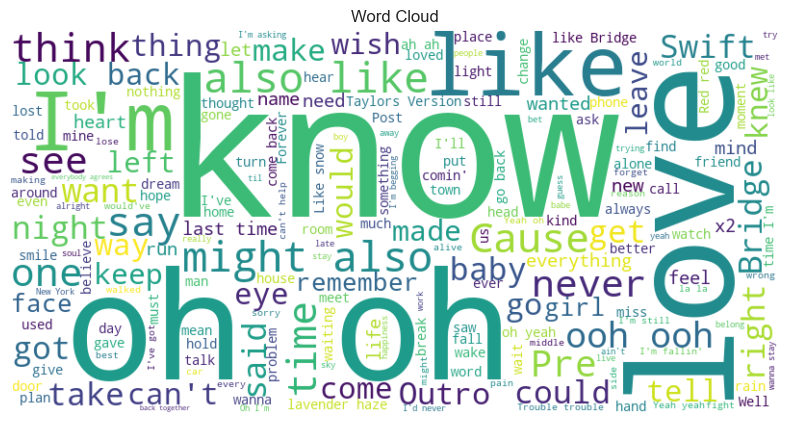

In [15]:
plt_data.plot_wordcloud(df, column_name='titled_lyrics_with_custom_eos', stopwords = stopwords_eng + ["Verse", "song", "Chorus", "Taylor", "title", 'END', "Generate","title"])

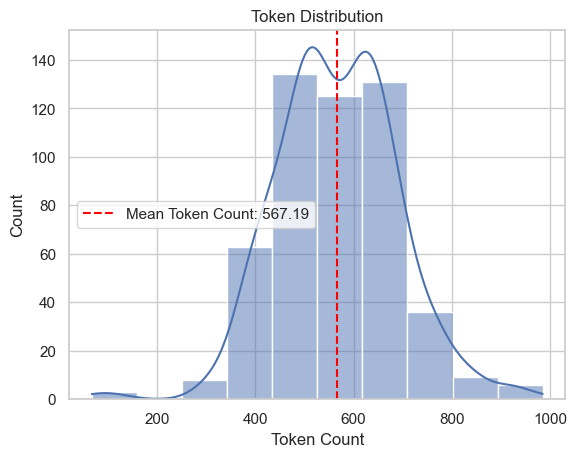

In [6]:
plt_data.plot_token_distribution(df, text_column="titled_lyrics_with_custom_eos")